<a href="https://colab.research.google.com/github/proliuk/TASK-B-EVALITA-HASPEED-2020/blob/main/MIGLIORI_MODELLI_Progetto_Evalita_RAM_UPGRADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tweet-preprocessor
!pip install tqdm
!pip install emoji
!pip install fasttext

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
import preprocessor as p
import re
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from nltk.stem import SnowballStemmer
from tqdm import tqdm
tqdm.pandas()
import csv
import emoji
len(stopwords.words('italian'))
from google.colab import drive
drive.mount('/content/drive')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import gzip

from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences

from string import punctuation
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
#new column in the dataframe
df_cols = ["Testo", "Odio", "Stereotipo"]

df = pd.read_table('/content/drive/MyDrive/Progetto Evalita/haspeede2_dev_taskAB.tsv', delimiter="\t|\t0",encoding='utf-8', names = df_cols, engine='python')
df = df.drop(df.index[0])

#change values in the column label based on values
df.Stereotipo.replace(to_replace ="1", value = 1, inplace = True)
df.Stereotipo.replace(to_replace ="0", value = 0, inplace = True)

In [ ]:
df = df[["Testo","Stereotipo"]]
df

,Testo,Stereotipo
2066,"È terrorismo anche questo, per mettere in uno ...",0
2045,@user @user infatti finché ci hanno guadagnato...,0
61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0
1259,"@user ad uno ad uno, perché quando i migranti ...",0
949,Il divertimento del giorno? Trovare i patrioti...,0
...,...,...
9340,Gli stati nazionali devono essere pronti a rin...,0
9121,Il ministro dell'interno della Germania #Horst...,0
8549,#Salvini: In Italia troppi si sono montati la ...,0
9240,@user @user Chi giubila in buona fede non ha c...,0


In [ ]:
print(df['Testo'].iloc[6808])

@user @user Questi analfabeti che schifate tanto sono quelli che con le loro tasse e le loro schiene mandano avanti il paese,fate proprio schifo con questo senso di superiorità.Nel frattempo imbarcate migranti ,futuri vostri elettori,tutti universitari! 😂😂😂😂 


In [ ]:
def custom_cleaning(text):
    # rimuovere simboli e converto le emoji in parole
    text  = " " + emoji.demojize(text, delimiters=(" ", " "), language="it")
    text  = "".join([char for char in text if char not in '"%\()*+-/<=>[]^_`{|}~�✔'])   
    text = re.sub(r"[,.;@#?!&$]+\ *", " ", text)
    
    # rimuovo le stopwords
    text = text.lower().split()
    text = [w for w in text if not w in stopwords.words('italian') and len(w) >= 3]
    text = " ".join(text)

    # rimuovere numeri e stringhe più caratteristiche dei dati
    text = re.sub('[0-9]+', '', text)
    text = re.sub('user', '', text)
    text = re.sub('url', '', text)
    text = re.sub("'", ' ', text)
    text = re.sub("…", ' ', text)
    text = re.sub("#", ' ', text)
    
    
    return text

In [ ]:
def stemming(text):

  text = text.split()
  stemmed_words = [SnowballStemmer('italian').stem(word) for word in text] 
  text = " ".join(stemmed_words)

  return text

In [ ]:
def clean_text(text):
  
  # I° pulizia del testo (stopwords, simboli, coversione emoji, caratteri non necessari)
  text_cleaned = custom_cleaning(text)

  # II° pulizia del testo tramite la libreria per i tweet
  p.set_options(p.OPT.NUMBER, p.OPT.URL)
  text_cleaned = p.clean(text_cleaned)

  # Stemmming del testo pulito
  #Ricordarsi di commentare quando usiamo il vocabolario di FASTTEXT poichè risulta migliore senza lo steamming delle parole
  text_cleaned = stemming(text_cleaned) 

  return text_cleaned

In [ ]:
df['Testo'] = df['Testo'].progress_map(lambda x: clean_text(x))

100%|██████████| 6839/6839 [00:35<00:00, 191.50it/s]


In [ ]:
X = df['Testo'].fillna('').to_list()
Y = df['Stereotipo'].fillna('').to_list()

In [ ]:
print(X[15])
print(Y[15])

rom torin graz colleg camp rom quintacolonn mediaset staser cal esponenzial furt deldebb
1


In [ ]:
#Contiano la lunghezza max e min delle frasi con e senza stereotipi
#e conto il numero di classi per gli stereotipi e non.
maxS = 0
minS = 0
maxNS = 0
minNS = 0
n_Stereotipi = 0 
n_NonStereotipi = 0 
FraseMaxS = ''
FraseMaxNS = ''

for ex in tqdm(range(len(X))):
  if Y[ex] == 1:
    n_Stereotipi += 1
    if len(X[ex]) > maxS:
      maxS = len(X[ex])
      FraseMaxS = X[ex]
    if len(X[ex]) < minS or minS == 0:
      minS = len(X[ex])
  else:
    n_NonStereotipi += 1
    if len(X[ex]) > maxNS:
      maxNS = len(X[ex])
      FraseMaxNS = X[ex]
    if len(X[ex]) < minNS or minNS == 0:
      minNS = len(X[ex])

print("Num Stereotipi: " + str(n_Stereotipi))
print("Num non Stereotipi: " + str(n_NonStereotipi))
print("Lunghezza Min Stereotipi: " + str(minS))
print("Lunghezza Max Stereotipi: " + str(maxS))
print(FraseMaxS)
print("Lunghezza Min Non Stereotipi: " + str(minNS))
print("Lunghezza Max Non Stereotipi: " + str(maxNS))
print(FraseMaxNS)  

100%|██████████| 6839/6839 [00:00<00:00, 936189.46it/s]

Num Stereotipi: 3042
Num non Stereotipi: 3797
Lunghezza Min Stereotipi: 5
Lunghezza Max Stereotipi: 384
ridereacrepapell ridereacrepapell ridereacrepapell faccinaconlacrimedigioi faccinaconlacrimedigioi faccinaconlacrimedigioi faccinaraggianteconocchifel faccinaraggianteconocchifel faccinaraggianteconocchifel sav sav rid vuo andar legg sav fals buonist pdiot ipocr radical chic grand amic migrant clandestin african delinquent senz document legg quas ugual quind sindac pag pegn giustiz
Lunghezza Min Non Stereotipi: 7
Lunghezza Max Non Stereotipi: 252
francescan chiud port protegg portafogl meg padron protegg ladr farabutt evasor tolg tass ricc sold pover cacc immigr tolg rdc negr zingar insult francescan faccinaconlacrimedigioi faccinaconlacrimedigioi faccinaconlacrimedigioi faccinaconlacrimedigioi


In [ ]:
RANDOM_STATE = 42

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
print(text_train[0])
print(text_train[1])

#TO DO : 
#Tokenize and transform to integer index
tokenizer = Tokenizer()

tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test  = tokenizer.texts_to_sequences(text_test)

#TO DO: get some statistics
vocab_size = len(tokenizer.word_index) + 1 # adding 1 because of reserverd 0 index

print("vocabulary size: ", vocab_size)

maxlen_train = max( len(x) for x in X_train)
maxlen_test = max( len(x) for x in X_test)

minlen_train = min( len(x) for x in X_train)
minlen_test = min( len(x) for x in X_test)

print("maxlen train dataset: ", maxlen_train)
print("maxlen test dataset: ", maxlen_test)

print("minlen train dataset: ", minlen_train)
print("minlen test dataset: ", minlen_test)


tokenizer.get_config()

In [ ]:
print("Esempio di un vettore di train :")
print(str(X_train[0]))
print("--------------------------")
print("Shape del train " + str(X_train.shape))

In [ ]:
# Add pading to ensure all vectors have same dimensionality
maxlen = maxlen_train

X_train = pad_sequences(X_train, padding = "post", maxlen = maxlen)
X_test = pad_sequences(X_test, padding = "post", maxlen = maxlen)

In [ ]:
print("Esempio di un vettore di train :")
print(str(X_train[0]))
print("--------------------------")
print("Shape del train " + str(X_train.shape))

Esempio di un vettore di train :
[1383 1214 6749 1384    4  910  659   24  540    2  307  613    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
--------------------------
Shape del train (5471, 38)


In [ ]:
print("Esempio di un vettore di test :")
print(str(X_test[0]))
print("--------------------------")
print("Shape del test " + str(X_test.shape))

Esempio di un vettore di test :
[ 120   29   37 2208  133 4024  499    7 1349  368    2 3687    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
--------------------------
Shape del test (1368, 38)


In [ ]:
def create_model(embedding_dim):

  model_dense = tf.keras.Sequential()
  model_dense.add(tf.keras.layers.Embedding(vocab_size,embedding_dim, input_length = maxlen))
  model_dense.add(tf.keras.layers.Flatten())
  model_dense.add(tf.keras.layers.Dense(64, activation = "relu", bias_initializer=tf.keras.initializers.Constant(0.1)))
  model_dense.add(tf.keras.layers.Dropout(0.3))
  model_dense.add(tf.keras.layers.Dense(32, activation = "relu", bias_initializer=tf.keras.initializers.Constant(0.1)))
  model_dense.add(tf.keras.layers.Dropout(0.3))
  model_dense.add(tf.keras.layers.Dense(16, activation = "relu", bias_initializer=tf.keras.initializers.Constant(0.1)))
  model_dense.add(tf.keras.layers.Dropout(0.3))
  model_dense.add(tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer="zeros"))

  model_dense.compile(optimizer = "adam", loss ="binary_crossentropy", metrics = ["accuracy"] )
  return model_dense

In [ ]:
model_dense = create_model(100) #Embedding Dim
model_dense.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 38, 100)           1053100   
_________________________________________________________________
flatten_19 (Flatten)         (None, 3800)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 64)                243264    
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_55 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 16)              

In [ ]:
# Fit model and get the history
history = model_dense.fit(np.array(X_train), np.array(y_train), epochs=10,verbose=True, validation_data=(np.array(X_test), np.array(y_test)),batch_size=1024)

Epoch 1/10
6/6 [==============================] - 1s 66ms/step - loss: 0.7005 - accuracy: 0.5257 - val_loss: 0.6901 - val_accuracy: 0.5358
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.6892 - accuracy: 0.5441 - val_loss: 0.6844 - val_accuracy: 0.5365
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.6820 - accuracy: 0.5619 - val_loss: 0.6829 - val_accuracy: 0.5563
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.6766 - accuracy: 0.5745 - val_loss: 0.6805 - val_accuracy: 0.5753
Epoch 5/10
6/6 [==============================] - 0s 39ms/step - loss: 0.6701 - accuracy: 0.5950 - val_loss: 0.6790 - val_accuracy: 0.5753
Epoch 6/10
6/6 [==============================] - 0s 38ms/step - loss: 0.6588 - accuracy: 0.6205 - val_loss: 0.6683 - val_accuracy: 0.5914
Epoch 7/10
6/6 [==============================] - 0s 38ms/step - loss: 0.6329 - accuracy: 0.6770 - val_loss: 0.6530 - val_accuracy: 0.6243
Epoch 8/10
6/6 [===========

In [ ]:
tf.keras.utils.plot_model(model_dense, show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=300
)


In [ ]:
#TO DO : evaluate the model 
loss, accuracy = model_dense.evaluate(np.array(X_test), np.array(y_test), verbose = 1)

43/43 [==============================] - 0s 2ms/step - loss: 0.5762 - accuracy: 0.7230


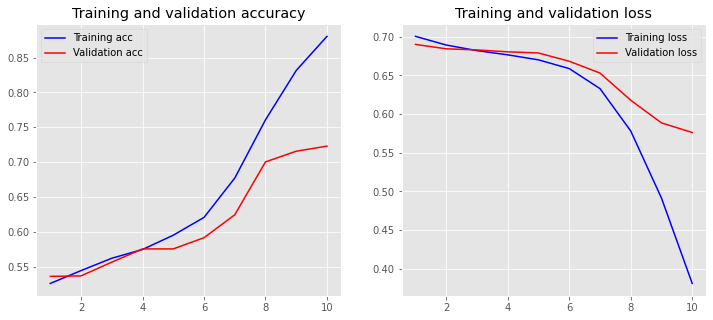

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history)

In [ ]:
y_pred = model_dense.predict_classes(X_test)
errori_commessi = 0
corretto = 0
count = 0
print()
for i in range(0, y_pred.size):
    count += 1
    if(np.around(y_pred[i], decimals = 0) != y_test[i]):
        errori_commessi+=1
    else:
        corretto+=1

from sklearn.metrics import accuracy_score
print("Accuratezza: ", accuracy_score(y_test,y_pred))
print()
print('Dimensione training set: ', np.array(y_train).size)
print('Dimensione test set: ', np.array(y_pred).size)
print()
print('Previsioni Corrette: ', corretto)
print('Errori Commessi: ', errori_commessi)
accuratezza = round((corretto/np.array(y_pred).size*100),2)
print('Accuratezza: ', accuratezza,'%')
print()
print(classification_report(y_test,y_pred))


Accuratezza:  0.722953216374269

Dimensione training set:  5471
Dimensione test set:  1368

Previsioni Corrette:  989
Errori Commessi:  379
Accuratezza:  72.3 %

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       733
           1       0.73      0.64      0.68       635

    accuracy                           0.72      1368
   macro avg       0.72      0.72      0.72      1368
weighted avg       0.72      0.72      0.72      1368



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


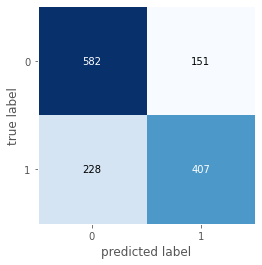

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [ ]:
#predizione di una frase 
x_sample = input("inserisci il tweet da predire: ")
print(x_sample)
x_sample = clean_text(x_sample)
x_sample=[x_sample]
print(x_sample)
x_sample_token = tokenizer.texts_to_sequences(x_sample)
print(x_sample_token)

x_sample_token = pad_sequences(x_sample_token, padding = "post", maxlen = maxlen)
print(x_sample_token)

print("La predizione è: ")
predizione = model_dense.predict_classes(x_sample_token)
print(predizione)

inserisci il tweet da predire: rom ladri e stupratori
rom ladri e stupratori
['rom ladr stuprator']
[[1, 176, 281]]
[[  1 176 281   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]
La predizione è: 
[[1]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


MODELLO CON VOCABOLARIO FASTTEXT


In [ ]:
print(X[15])
print(Y[15])

roma torino grazie collegamento campi rom quintacolonna mediaset stasera calo esponenziale furti deldebbio
1


In [ ]:
import fasttext
import fasttext.util

In [ ]:
ft = fasttext.load_model('/content/drive/MyDrive/Progetto Evalita/cc.it.100.bin')

In [ ]:
ft.get_word_vector('gatto').shape

(100,)

In [ ]:
ft.get_nearest_neighbors('gatto')

[(0.8999981880187988, 'cane'),
 (0.8771999478340149, 'gattino'),
 (0.8680503964424133, 'criceto'),
 (0.8668853044509888, 'micio'),
 (0.8596745133399963, 'coniglio'),
 (0.8556078672409058, 'topo'),
 (0.8519355654716492, 'pappagallo'),
 (0.8409976959228516, 'cucciolo'),
 (0.8267292976379395, 'felino'),
 (0.8143686056137085, 'cagnolino')]

creo matrice e modello con fasttext

In [ ]:
embedding_dim = 100

In [ ]:
embeddings_matrix = np.zeros((vocab_size, embedding_dim)) 
print(vocab_size)

16370


In [ ]:
count1 = 0
count2 = 0
for word, index in tokenizer.word_index.items():
  if index > vocab_size-1:
    break
  embedding_vector = ft.get_word_vector(word)
  if embedding_vector is not None:
    embeddings_matrix[index] = embedding_vector
    count1 += 1
  else:
    count2 += 1
print("Parole del nostro vocabolario presenti nella matrice: "+ str(count1))
print("Parole del nostro vocabolario non presenti nella matrice: "+ str(count2))

Parole del nostro vocabolario presenti nella matrice: 16369
Parole del nostro vocabolario non presenti nella matrice: 0


In [ ]:
model_prova = tf.keras.Sequential()
model_prova.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, weights = [embeddings_matrix], trainable = False))
model_prova.add(tf.keras.layers.Flatten())
model_prova.add(tf.keras.layers.Dense(128, activation='relu', bias_initializer='zeros' ))
model_prova.add(tf.keras.layers.Dense(64, activation='relu', bias_initializer='zeros' ))
model_prova.add(tf.keras.layers.Dense(32, activation='relu', bias_initializer='zeros' ))
model_prova.add(tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer='zeros' ))
model_prova.compile(optimizer = "adam", loss ="binary_crossentropy", metrics = ["accuracy"] )
model_prova.summary()

Model: "sequential_180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_180 (Embedding)    (None, 38, 100)           1637000   
_________________________________________________________________
flatten_180 (Flatten)        (None, 3800)              0         
_________________________________________________________________
dense_637 (Dense)            (None, 128)               486528    
_________________________________________________________________
dense_638 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_639 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_640 (Dense)            (None, 1)                 33        
Total params: 2,133,897
Trainable params: 496,897
Non-trainable params: 1,637,000
____________________________________

In [ ]:
history = model_prova.fit(np.array(X_train), np.array(y_train), epochs=4,verbose=True, validation_data=(np.array(X_test), np.array(y_test)),batch_size=128)

Epoch 1/4
43/43 [==============================] - 1s 13ms/step - loss: 0.6627 - accuracy: 0.6061 - val_loss: 0.6442 - val_accuracy: 0.6243
Epoch 2/4
43/43 [==============================] - 0s 10ms/step - loss: 0.5772 - accuracy: 0.6959 - val_loss: 0.6353 - val_accuracy: 0.6506
Epoch 3/4
43/43 [==============================] - 0s 10ms/step - loss: 0.4886 - accuracy: 0.7600 - val_loss: 0.6405 - val_accuracy: 0.6696
Epoch 4/4
43/43 [==============================] - 0s 9ms/step - loss: 0.4091 - accuracy: 0.8132 - val_loss: 0.6692 - val_accuracy: 0.6762


In [ ]:
loss, accuracy = model_prova.evaluate(np.array(X_test), np.array(y_test), verbose = 1)

43/43 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6762


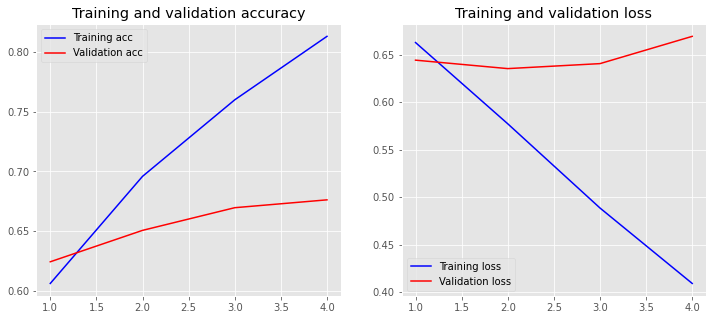

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history)

In [ ]:
y_pred = model_prova.predict_classes(X_test)#, batch_size = 20, verbose = 1)
errori_commessi = 0
corretto = 0
count = 0
print()
for i in range(0, y_pred.size):
    count += 1
    if(np.around(y_pred[i], decimals = 0) != y_test[i]):
        errori_commessi+=1
    else:
        corretto+=1

cm = confusion_matrix(y_test,y_pred)

print()
print()
print('Utilizzati come training set: ', np.array(y_train).size)
print('Utilizzati come test set: ', np.array(y_pred).size)
print()
print('Previsioni Corrette: ', corretto)
print('Errori Commessi: ', errori_commessi)
accuratezza = round((corretto/np.array(y_pred).size*100),2)
print('Accuratezza: ', accuratezza,'%')
print()
print(classification_report(y_test,y_pred))
print('Matrice di Confusione:')
print(cm)

#or just use the sklearn accuracy metric
from sklearn.metrics import accuracy_score
print("Accuratezza con la funzione: ", accuracy_score(y_test,y_pred))




Utilizzati come training set:  5471
Utilizzati come test set:  1368

Previsioni Corrette:  925
Errori Commessi:  443
Accuratezza:  67.62 %

              precision    recall  f1-score   support

           0       0.70      0.69      0.70       733
           1       0.65      0.66      0.65       635

    accuracy                           0.68      1368
   macro avg       0.67      0.67      0.67      1368
weighted avg       0.68      0.68      0.68      1368

Matrice di Confusione:
[[507 226]
 [217 418]]
Accuratezza con la funzione:  0.6761695906432749


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


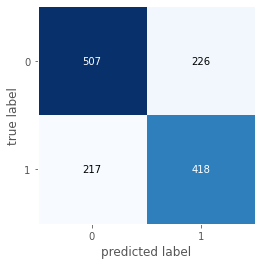

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [ ]:
#predizione di una frase 
x_sample = input("inserisci il tweet da predire: ")
print(x_sample)
x_sample = clean_text(x_sample)
x_sample=[x_sample]
print(x_sample)
x_sample_token = tokenizer.texts_to_sequences(x_sample)
print(x_sample_token)

x_sample_token = pad_sequences(x_sample_token, padding = "post", maxlen = maxlen)
print(x_sample_token)

print("La predizione è: ")
predizione = model_prova.predict_classes(x_sample_token)
print(predizione)


inserisci il tweet da predire: terroni ladri
terroni ladri
['terroni ladri']
[[3639, 251]]
[[3639  251    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
La predizione è: 
[[1]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


**CAPIRE DOVE SBAGLIA IL MODELLO**

In [ ]:
for i in range(0, len(Test_label)):

  x_sample=[Test_record[i]]
  x_sample_token = tokenizer.texts_to_sequences(x_sample)
  x_sample_token = pad_sequences(x_sample_token, padding = "post", maxlen = maxlen)
  predizione = model_dense.predict_classes(x_sample_token)
  if predizione[0][0] != Test_label[i]:
      print("Il modello ha predetto "+str(predizione[0][0]))
      print("Il record era classe "+str(Test_label[i]))
      print(Test_record[i])